In [215]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


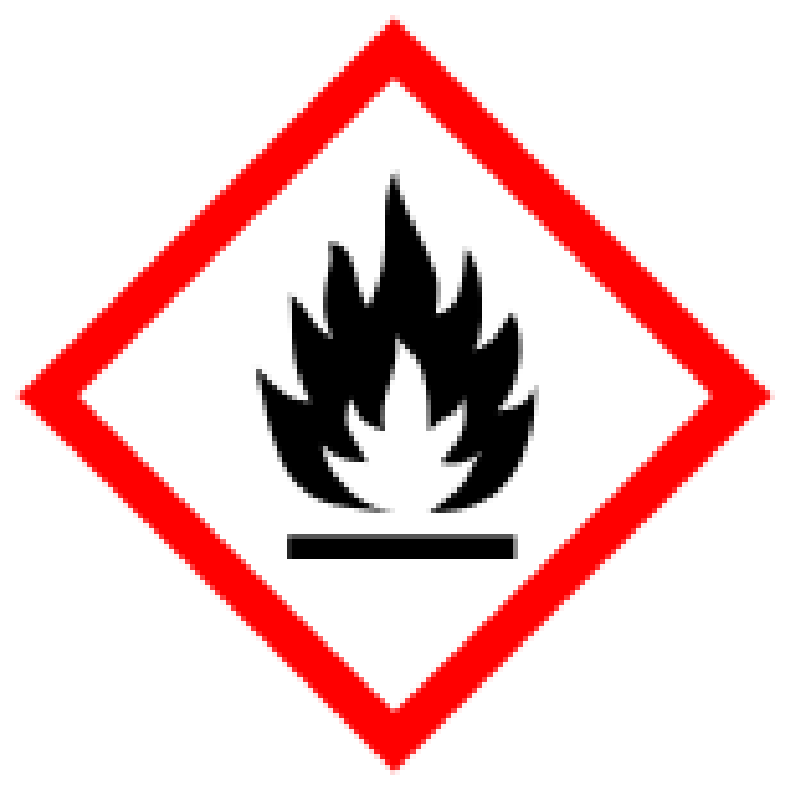

In [216]:
filename = "GHS_00016.png"
folder = "/Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/templates/"

image = folder + filename
image = cv2.imread(image, cv2.IMREAD_UNCHANGED)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# scale = 1
# image = cv2.resize(image, (int(image.shape[1] * scale), int(image.shape[0] * scale)))

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGBA))
plt.axis('off')
plt.show()

In [217]:
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

ORB = cv2.ORB_create(nfeatures=1000)
keypoints, descriptors = ORB.detectAndCompute(image_gray, None)

# SIFT = cv2.SIFT_create()
# keypoints, descriptors = SIFT.detectAndCompute(image_gray, None)

print(f"Number of keypoints detected: {len(keypoints)}")

Number of keypoints detected: 133


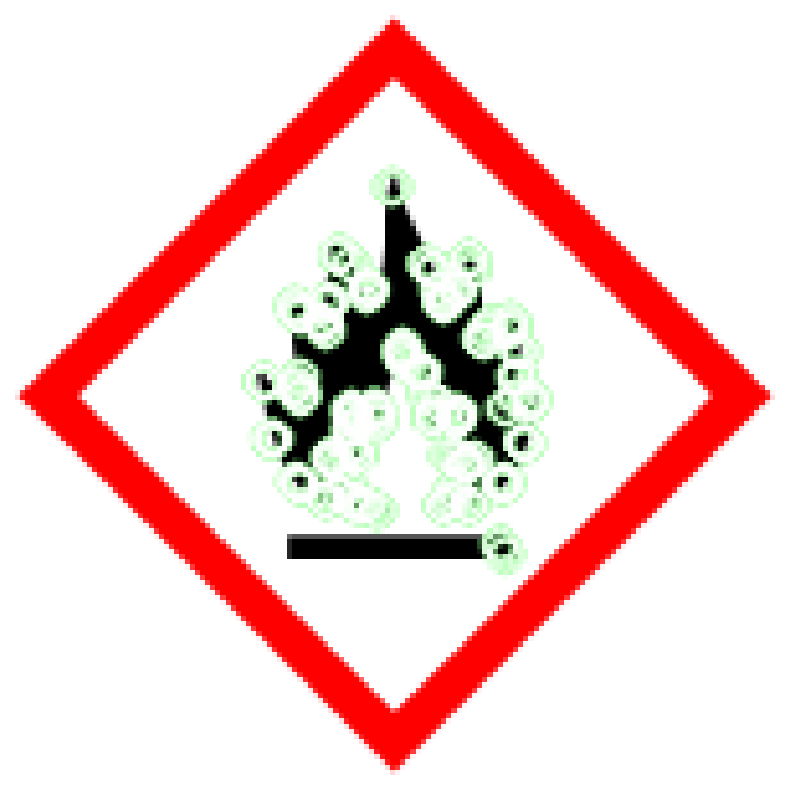

In [218]:
# Visualize keypoints
image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGBA))
plt.axis('off')	
plt.show()


In [219]:
# LSD Line Segment Detector
lsd = cv2.line_descriptor.LSDDetector.createLSDDetector()

In [220]:
keylines_raw_template = lsd.detect(image, scale=2, numOctaves=3)
len(keylines_raw_template)

43

Total endpoints detected: 86
Number of unique endpoints: 42


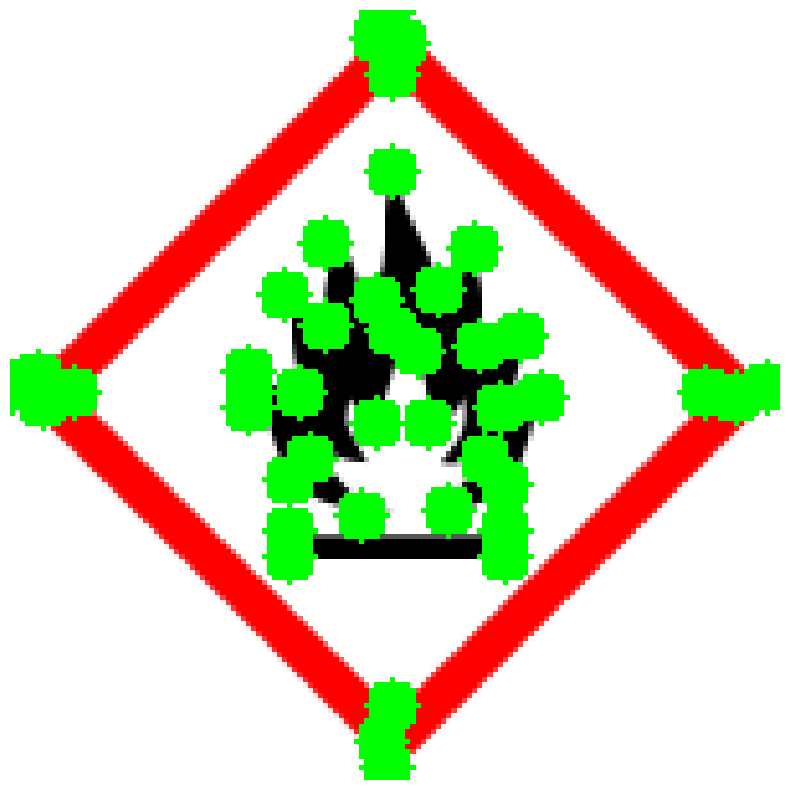

In [221]:
# Extract all endpoints from keylines_raw_template
points = []
for kl in keylines_raw_template:
	pt1 = (int(kl.startPointX), int(kl.startPointY))
	pt2 = (int(kl.endPointX), int(kl.endPointY))
	points.append(pt1)
	points.append(pt2)

print(f"Total endpoints detected: {len(points)}")

# Non-maxima suppression to remove duplicates within epsilon
epsilon = 5  # pixels
unique_points = []
for pt in points:
	if not any(np.linalg.norm(np.array(pt) - np.array(up)) < epsilon for up in unique_points):
		unique_points.append(pt)

print(f"Number of unique endpoints: {len(unique_points)}")

# Plot unique endpoints over the image
image_with_unique_points = image.copy()
for pt in unique_points:
	cv2.circle(image_with_unique_points, pt, radius=5, color=(0, 255, 0, 255), thickness=-1)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cv2.cvtColor(image_with_unique_points, cv2.COLOR_BGR2RGBA))
plt.axis('off')	
plt.show()

In [222]:
kp_epsilon = 5

# Convert keypoints to (x, y) tuples
keypoints_xy = [tuple(map(int, kp.pt)) for kp in keypoints]

print(f"Number of keypoints before filtering: {len(keypoints_xy)}")
print(f"Number of line-derived unique points: {len(unique_points)}")

# Retain only keypoints within kp_epsilon of any unique_point, and remove matched unique_point
filtered_keypoints = []
filtered_descriptors = []
remaining_unique_points = unique_points.copy()
for kp, xy in zip(keypoints, keypoints_xy):
	for i, up in enumerate(remaining_unique_points):
		if np.linalg.norm(np.array(xy) - np.array(up)) < kp_epsilon:
			filtered_keypoints.append(kp)
			filtered_descriptors.append(descriptors[keypoints.index(kp)])
			# Remove the matched unique_point so it can't match again
			remaining_unique_points.pop(i)
			break

print(f"Number of filtered keypoints: {len(filtered_keypoints)}")
print(f"Remaining line-derived unique points after filtering: {len(remaining_unique_points)}")

total_keypoints = len(filtered_keypoints) + len(remaining_unique_points)
percent_from_original = (total_keypoints / len(keypoints)) * 100
print(f"Total final keypoints: {total_keypoints} ({int(percent_from_original)}% from original keypoints)")

Number of keypoints before filtering: 133
Number of line-derived unique points: 42
Number of filtered keypoints: 25
Remaining line-derived unique points after filtering: 17
Total final keypoints: 42 (31% from original keypoints)


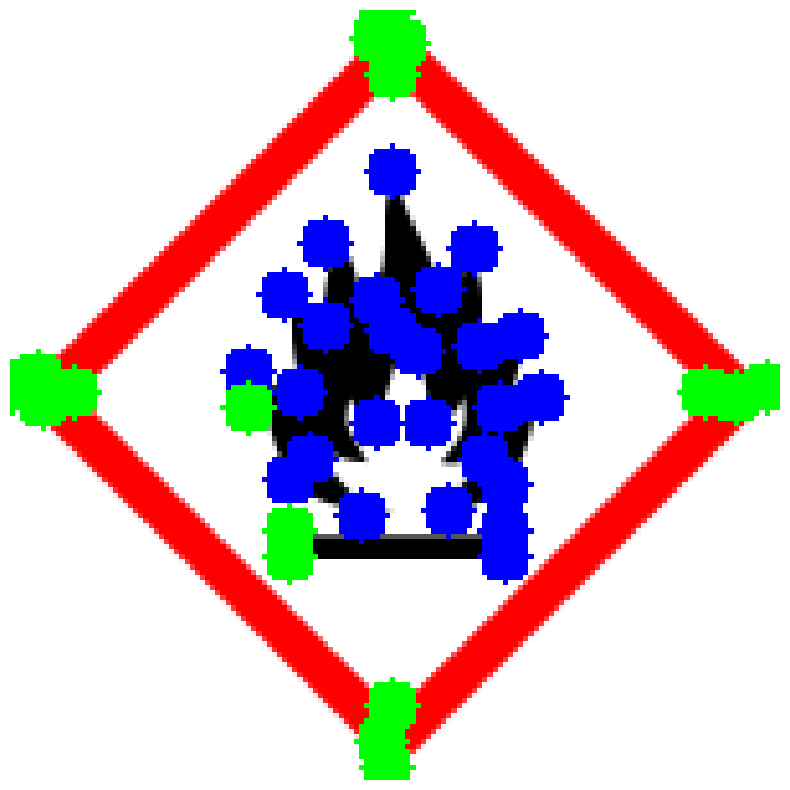

In [223]:
# Visualize the line-derived `unique_points` in blue and then the `remaining_unique_points` in green over them

image_with_filtered_keypoints = image.copy()
for pt in unique_points:
	cv2.circle(image_with_filtered_keypoints, pt, radius=5, color=(255, 0, 0, 255), thickness=-1)
for pt in remaining_unique_points:
	cv2.circle(image_with_filtered_keypoints, pt, radius=5, color=(0, 255, 0, 255), thickness=-1)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))	
ax.imshow(cv2.cvtColor(image_with_filtered_keypoints, cv2.COLOR_BGR2RGBA))
plt.axis('off')
plt.show()

In [224]:
# Compute descriptors for the `remaining_unique_points` and join them with the filtered keypoints descriptors

if len(remaining_unique_points) > 0:
	# Create keypoints
	remaining_keypoints = [cv2.KeyPoint(xy[0], xy[1], 1) for xy in remaining_unique_points]

	# Compute descriptors
	remaining_descriptors = ORB.compute(image_gray, remaining_keypoints)[1]

	# Join with existing (kp, desc)
	combined_keypoints = filtered_keypoints + remaining_keypoints
	combined_descriptors = filtered_descriptors + remaining_descriptors.tolist()

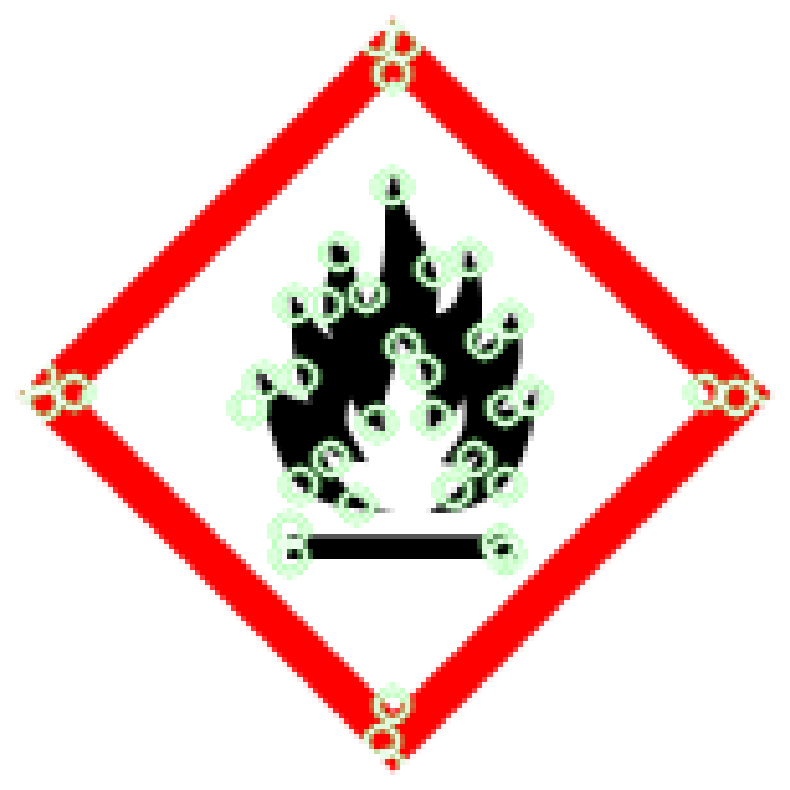

In [225]:
# Visualize keypoints
image_with_keypoints = cv2.drawKeypoints(image, combined_keypoints, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGBA))
plt.axis('off')	
plt.show()
